In [366]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

In [691]:
def detect_staff(music_sheet):
    _,music_sheet_bi = cv.threshold(music_sheet,0, 1, cv.THRESH_BINARY+cv.THRESH_OTSU)

    col_hist = np.sum(music_sheet_bi, axis=0)
    col_hist = np.float32(col_hist)
    col_hist_norm = col_hist.copy()

    cv.normalize(col_hist,col_hist_norm,0,1, norm_type=cv.NORM_MINMAX)

    indices = np.where(col_hist_norm >= 1)
    indices = indices[0]

    for i in range(len(indices)):
        if indices[i+1]-indices[i] > 2:
            #s_index = indices[i]
            e_index = indices[i+1]
            break
            
    music_sheet_bi = music_sheet_bi[0:-1,0:e_index]    

    row_hist = np.sum(music_sheet_bi, axis=1)
    row_hist = np.float32(row_hist)
    row_hist_norm = row_hist.copy()

    cv.normalize(row_hist,row_hist_norm,0,1, norm_type=cv.NORM_MINMAX)

    row_hist_norm = 1-row_hist_norm
    staff,_ = signal.find_peaks(row_hist_norm, height=0.9)

    s_staff_b = []
    s_staff_n = []
    e_staff = []

    for i in range(len(staff)):
        if i%5 == 0:
            s_staff_b.append(staff[i]-40)
            s_staff_n.append(staff[i]-15)
        elif i%5 == 4:
            e_staff.append(staff[i]+1)
            
    return music_sheet_bi, s_staff_b, s_staff_n, e_staff

In [692]:
def crop_staff(img,start,method,s_staff_b,s_staff_n,e_staff,threshold=0.9):

    img2 = img.copy()
    res = cv.matchTemplate(img2,start,method)
    cv.normalize(res,res,0,1, norm_type=cv.NORM_MINMAX)
    
    loc = np.where(res > threshold)

    point_w = []
    point_h = []

    start_w,start_h = start.shape[::-1]
    
    for pt in zip(*loc[::-1]):
        cv.rectangle(img2, pt, (pt[0] + start_w, pt[1] + start_h), (0,0,255), 1)
        point_w.append(pt[0])
        point_h.append(pt[1])
    
    i = 1
    while i < len(point_h):
        prev = point_h[i-1]
        post = point_h[i]

        if (post-prev < 30):
            del point_h[i-1]
            del point_w[i-1]
        else:
            i += 1
    
    crops_n = []
    crops_b = []

    for i in range(len(point_h)):

        crops_n.append(img[s_staff_n[i]:e_staff[i],point_w[i]+start_w:-1])
        crops_b.append(img[s_staff_b[i]:s_staff_n[i],point_w[i]+start_w:-1])
    
    return img2, point_w, point_h, crops_n, crops_b

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x231ce562da0>)

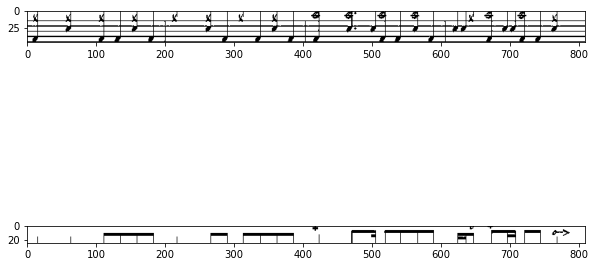

In [693]:
music_sheet = cv.imread('C:/Users/ADmin/Desktop/drum/music_sheet/'+'/6.jpg',0)

music_sheet_bi, s_staff_b, s_staff_n, e_staff = detect_staff(music_sheet)

start = cv.imread('C:/Users/ADmin/Desktop/start.jpg',0)

meth = 'cv.TM_CCOEFF'
method = eval(meth)

img2, _, _, staff_crops_n, staff_crops_b = crop_staff(music_sheet_bi,start,method,s_staff_b,s_staff_n,e_staff,0.9)

plt.figure(figsize=[10,7])
plt.subplot(2,1,1),plt.imshow(staff_crops_n[2],cmap='gray')
plt.subplot(2,1,2),plt.imshow(staff_crops_b[2],cmap='gray')

(0.0, 809.0)

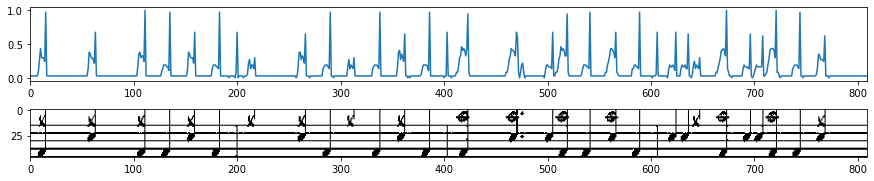

In [694]:
crop_notes = staff_crops_n[2]
col_hist = np.sum(crop_notes, axis=0)
col_hist = np.float32(col_hist)
col_hist_norm = col_hist.copy()

cv.normalize(col_hist,col_hist_norm,0,1, norm_type=cv.NORM_MINMAX)

inv_col_hist_norm = 1-col_hist_norm

plt.figure(figsize=[15,3])
plt.subplot(2,1,1),plt.plot(inv_col_hist_norm)
plt.xlim(0,len(inv_col_hist_norm))
plt.subplot(2,1,2), plt.imshow(crop_notes,cmap = 'gray')
plt.xlim(0,len(inv_col_hist_norm))

(0.0, 809.0)

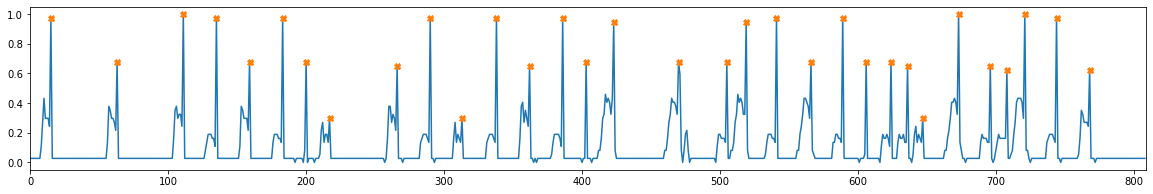

In [695]:
peaks,_ = signal.find_peaks(inv_col_hist_norm, height=0.2, distance=8)

plt.figure(figsize=[20,3])
plt.plot(inv_col_hist_norm),plt.plot(peaks,inv_col_hist_norm[peaks],"X")
plt.xlim(0,len(inv_col_hist_norm))

In [696]:
peaks

array([ 15,  63, 111, 135, 159, 183, 200, 217, 266, 290, 313, 338, 362,
       386, 403, 423, 470, 505, 519, 541, 566, 589, 606, 624, 636, 647,
       673, 696, 708, 721, 744, 768], dtype=int64)

In [697]:
stack_peaks = []

for i in peaks:
    stack_peaks.append(np.sum(1-inv_col_hist_norm[i-3:i]))

a = stack_peaks.copy()

lines_index = []

for i in range(3): 
    lines_index.append(np.where(a == np.max(a))[0][0])
    a[lines_index[i]] = 0

In [698]:
lines_index

[14, 6, 22]

In [700]:
notes_loc = np.delete(peaks, lines_index)
notes_loc

array([ 15,  63, 111, 135, 159, 183, 217, 266, 290, 313, 338, 362, 386,
       423, 470, 505, 519, 541, 566, 589, 624, 636, 647, 673, 696, 708,
       721, 744, 768], dtype=int64)

(0.0, 809.0)

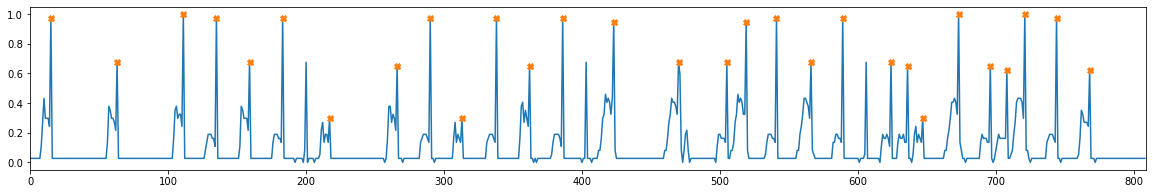

In [701]:
plt.figure(figsize=[20,3])
plt.plot(inv_col_hist_norm),plt.plot(notes_loc,inv_col_hist_norm[notes_loc],"X")
plt.xlim(0,len(inv_col_hist_norm))

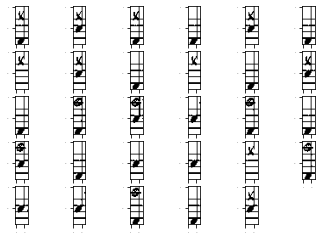

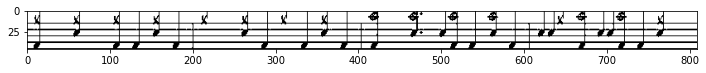

In [702]:
notes = []
for i in range(len(notes_loc)):
    note = crop_notes[0:crop_img.shape[0],notes_loc[i]-10:notes_loc[i]+5]
    notes.append(note)
    
for i in range(len(notes)):
    plt.subplot(5,len(notes)//5+1,i+1)
    plt.imshow(notes[i],cmap='gray')
    plt.xticks(fontsize=0.1)
    plt.yticks(fontsize=0.1)
    
plt.figure(figsize=[12,5])
plt.imshow(crop_notes,cmap = 'gray')

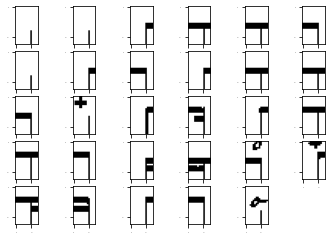

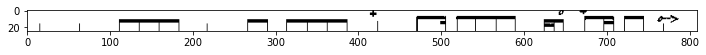

In [703]:
crop_beats = staff_crops_b[2]
beats = []

for i in range(len(notes_loc)):
    beat = crop_beats[0:crop_beats.shape[0],notes_loc[i]-10:notes_loc[i]+5]
    beats.append(beat)
    
for i in range(len(beats)):
    plt.subplot(5,len(beats)//5+1,i+1)
    plt.imshow(beats[i],cmap='gray')
    plt.xticks(fontsize=0.1)
    plt.yticks(fontsize=0.1)
    
plt.figure(figsize=[12,5])
plt.imshow(crop_beats,cmap = 'gray')

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x231cb66ef98>)

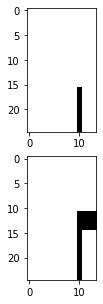

In [704]:
beat_crop_1 = beats[0][0:25,0:-1]
beat_crop_2 = beats[2][0:25,0:-1]

plt.figure(figsize=[12,5])
plt.subplot(2,1,1),plt.imshow(beat_crop_1,cmap = 'gray')
plt.subplot(2,1,2),plt.imshow(beat_crop_2,cmap = 'gray')

In [705]:
def one_or_two(note_crop, method):
    process_img = note_crop.copy()
    img = note_crop.copy()
    
    square = np.zeros([8,8])
    #square = np.pad(square,(2,2),mode = 'constant', constant_values = 1)
    square = square.astype(np.uint8)

    orig_res = cv.matchTemplate(process_img,square,method)
    
    points = []
    
    for i in range(2):
        res = cv.matchTemplate(process_img,square,method)
        res_norm = res.copy()

        cv.normalize(res,res_norm,0,1, norm_type=cv.NORM_MINMAX)

        minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(res_norm)

        x,y = minLoc
        h,w = square.shape        

        if i == 0:
            process_img[y:y+h, x:x+w] = np.max(process_img)
            cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 1)
        else:
            avg = np.mean(process_img[y:y+h, x:x+w])

            if avg < 0.5:
                cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 1)
                print ("two note")
            else:
                print ("one note")
                break
        
        point = x+w//2,y+h//2
        points.append(point)
                
    return orig_res,img,points

one note
[(7, 12)]


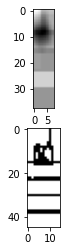

In [706]:
meth = 'cv.TM_SQDIFF'
method = eval(meth)

note = notes[22]
orig_res, img, points = one_or_two(note, method)

print(points)

plt.figure(figsize=[10,4])
plt.title(method)
plt.subplot(2,1,1), plt.imshow(orig_res,cmap = 'gray')
plt.subplot(2,1,2), plt.imshow(img,cmap = 'gray')

plt.show()

In [ ]:
"""문제
meth = 'cv.TM_SQDIFF'
method = eval(meth)

note_crop = note_crops[24]
orig_res, img, points = one_or_two(note_crop, method)

print(points)

plt.figure(figsize=[10,4])
plt.title(method)
plt.subplot(2,1,1), plt.imshow(orig_res,cmap = 'gray')
plt.subplot(2,1,2), plt.imshow(img,cmap = 'gray')

plt.show()
"""

In [707]:
f_line = crop_img[:,1]

i = 1
while i < len(f_line):
    prev = f_line[i-1]
    post = f_line[i]

    if (post==0 & prev==0):
        f_line =np.delete(f_line,i-1)
    else:
        i += 1

In [708]:
f_line

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], dtype=uint8)

<StemContainer object of 3 artists>

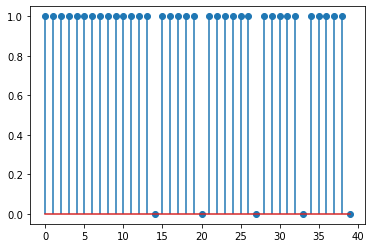

In [709]:
plt.stem(f_line)    

In [713]:
staff_lines = []
f = f_line.copy()
for i in range(5):
    staff_lines.append(np.where(f == np.min(f))[0][0])
    f[staff_lines[i]] = 1
del f

In [714]:
staff_lines

[14, 20, 27, 33, 39]

In [715]:
ride = [0,staff_lines[0]-7]
hihat = [staff_lines[0]-7,staff_lines[0]]
snare = [staff_lines[2] - 1,staff_lines[2] + 1]
h_tom = [(staff_lines[0]+staff_lines[1])//2 - 1,(staff_lines[0]+staff_lines[1])//2 + 1]
m_tom = [(staff_lines[1]+staff_lines[2])//2 - 1,(staff_lines[1]+staff_lines[2])//2 + 1]
l_tom = [(staff_lines[2]+staff_lines[3])//2 - 1,(staff_lines[2]+staff_lines[3])//2 + 1]
bass = [(staff_lines[3]+staff_lines[4])//2 - 1]#,(staff_lines[3]+staff_lines[4])//2 + 1]

note = []
for i in range(len(points)):
    if ride[0] <= points[i][1] <=  ride[1]:
        note.append('Ride')
    elif hihat[0] <= points[i][1] <=  hihat[1]:
        note.append('Hihat')
    elif snare[0] <= points[i][1] <=  snare[1]:
        note.append('Snare')
    elif h_tom[0] <= points[i][1] <=  h_tom[1]:
        note.append('High_Tom')
    elif m_tom[0] <= points[i][1] <=  m_tom[1]:
        note.append('Mid_Tom')
    elif l_tom[0] <= points[i][1] <=  l_tom[1]:
        note.append('Low_Tom')   
    elif bass[0] <= points[i][1] :
        note.append('Bass')     
    else:
        note.append('error') 

In [716]:
print(note)

['Hihat']
